In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
import matplotlib.pyplot as plt
from datetime import datetime
# Get the current time
current_time = datetime.now()
# Print the current time
print("Current time:", current_time)
!pip install dataretrieval
from dataretrieval import nwis
import random
from google.colab import drive
drive.mount('/content/drive')
!pip install hydroeval
import hydroeval as he
# Set seeds for all major libraries
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Current time: 2025-05-25 18:57:03.229876
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# --- 1. Generate Sample Data (Replace with your actual DataFrame) ---
# Assuming your DataFrame 'df' is already loaded.
# For demonstration, let's create a sample DataFrame:
#np.random.seed(42) # for reproducibility
#dates = pd.to_datetime(pd.date_range(start='2020-01-01', periods=200, freq='D'))
#x1 = np.sin(np.linspace(0, 50, 200)) + np.random.rand(200) * 0.5
#x2 = np.cos(np.linspace(0, 40, 200)) * 0.8 + np.random.rand(200) * 0.3
#y = 0.7 * x1 + 0.3 * x2 + np.sin(np.linspace(0, 60, 200)) * 0.5 + np.random.rand(200) * 0.2
#df = pd.DataFrame({'date': dates, 'x1': x1, 'x2': x2, 'y': y})

#print("Sample DataFrame Head:")
#print(df.head())
#print("\nDataFrame Info:")
#df.info()

In [3]:
startDate = "1995-10-01"
endDate = "2024-09-30"
model_site = [
    '13307000' # '13342500' #'13311000' # '13310850' # '13340600' #'13340000' #  '13317660'#    '13154500' #'12322000' #'12305000' #   '13176400'  #'13340000'#'13176400' # #"13311450" # "13296000"
]
units_day = 365
missing_data_threshold = 0.90 *365

summer_months = [6,7,8]
summer_missing_data_threshold = 0.90 * (30+31+31)

site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
print("site_info_df:",site_info_df)
print("station_nm:",site_info_df['station_nm'][0])
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'station_nm','dec_lat_va', 'dec_long_va', 'drain_area_va', 'contrib_drain_area_va' ,   'alt_va'
                  # ,'alt_meth_cd', 'alt_acy_va', 'alt_datum_cd'
                  ]
filtered_df = site_info_df[columns_to_save]



parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate)
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )
dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year

shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)
prism_df['date'] = pd.to_datetime( prism_df['date'])

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365

prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
#prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)
# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)
#print( prism_df)
prism_df['Date'] = prism_df['date'].dt.date

prism_df = prism_df[['tmean' , "site_no", 'Date'
#, "rad_d"
 ]]

dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',
  '00010_Mean', '00060_Mean'
  #,      'Month', 'Year'
   ]]

result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')

# Count the number of NaN values in each column
na_count = result.isna().sum()

# Drop rows with any NaN values
df_cleaned = result.dropna()

df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

train_month =  list(range( 3 , 8+1 ))


print("train_month:", train_month)

df_cleaned= df_cleaned[ df_cleaned['Date'].dt.month.isin( train_month )]

# Print the cleaned DataFrame
print("df_cleaned:",df_cleaned)

# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()

print(na_count)

site_info_df:   agency_cd   site_no                station_nm site_tp_cd  lat_va  long_va  \
0      USGS  13307000  SALMON RIVER NR SHOUP ID         ST  451921  1142624   

   dec_lat_va  dec_long_va coord_meth_cd coord_acy_cd  ... reliability_cd  \
0     45.3225      -114.44             N            S  ...              C   

  gw_file_cd  nat_aqfr_cd  aqfr_cd  aqfr_type_cd well_depth_va hole_depth_va  \
0   NNNNNNNN          NaN      NaN           NaN           NaN           NaN   

  depth_src_cd  project_no                 geometry  
0          NaN         NaN  POINT (-114.44 45.3225)  

[1 rows x 43 columns]
station_nm: SALMON RIVER NR SHOUP ID
train_month: [3, 4, 5, 6, 7, 8]
df_cleaned:           tmean   site_no       Date  00010_Mean  00060_Mean
4902   2.858000  13307000 2016-03-03         4.6      1740.0
4903   3.634000  13307000 2016-03-04         4.9      1730.0
4904   6.690001  13307000 2016-03-05         5.7      1750.0
4905   2.485000  13307000 2016-03-06         5.8      1

<ipython-input-3-35bd2eba96ce>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])


In [4]:
#features = ['x1', 'x2']
#target = 'y'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
#scaler_features = MinMaxScaler(feature_range=(0, 1))
#scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit and transform features
#df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
#df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

#print("\nDataFrame after Normalization Head:")
#print(df.head())

In [5]:
# --- 2. Preprocessing ---
# Select features and target
features = ['tmean',  '00060_Mean' ]
target = '00010_Mean'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

print(df_cleaned.shape)
df = df_cleaned
print(df.shape)
# Fit and transform features
df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

print("\nDataFrame after Normalization Head:")
print(df.head())
print(df.tail())
print(df.shape)

(1612, 5)
(1612, 5)

DataFrame after Normalization Head:
         tmean   site_no       Date  00010_Mean  00060_Mean
4902  0.344081  13307000 2016-03-03    0.196653    0.045422
4903  0.364658  13307000 2016-03-04    0.209205    0.044941
4904  0.445693  13307000 2016-03-05    0.242678    0.045902
4905  0.334190  13307000 2016-03-06    0.246862    0.049267
4906  0.334455  13307000 2016-03-07    0.230126    0.053112
         tmean   site_no       Date  00010_Mean  00060_Mean
8001  0.754131  13307000 2024-08-27    0.769874    0.005239
8002  0.608749  13307000 2024-08-28    0.736402    0.004518
8003  0.704668  13307000 2024-08-29    0.715481    0.003028
8004  0.804984  13307000 2024-08-30    0.736402    0.002211
8005  0.830521  13307000 2024-08-31    0.757322    0.002115
(1612, 5)


In [6]:
# --- 3. Create Sequences for LSTM ---
# LSTMs require data in a 3D format: (samples, timesteps, features)
# 'timesteps' (also known as look_back) determines how many previous time steps
# the LSTM will consider to predict the next value.

look_back = 90 # You can adjust this based on your data's seasonality/dependencies

def create_sequences(data, look_back, features_cols, target_col):
    X, Y = [], []
    # Ensure data is a numpy array for efficient indexing
    data_np = data[features_cols + [target_col]].values # include target for sequence alignment
    #print(data.head)
    print(data_np)
    # Features are the first 'num_features' columns, target is the last column.
    num_features = len(features_cols)

    for i in range(len(data_np) - look_back):
        # X: look_back historical features (x1, x2)
        X.append(data_np[i:(i + look_back), :num_features])
        # Y: the 'y' value at the current time step (i + look_back)
        Y.append(data_np[i + look_back, num_features]) # Target is the last column


    return np.array(X), np.array(Y)

X, Y = create_sequences(df, look_back, features, target)

# Print first 4 elements
print("First 4 Y elements:", Y[:4])

# Print last 4 elements
print("Last 4 Y elements:", Y[-4:])

print(f"\nShape of X (samples, timesteps, features): {X.shape}")
print(f"Shape of Y (samples, target_value): {Y.shape}")

[[0.34408056 0.04542177 0.19665272]
 [0.36465751 0.04494112 0.20920502]
 [0.44569252 0.04590243 0.24267782]
 ...
 [0.70466773 0.00302812 0.71548117]
 [0.80498433 0.00221101 0.73640167]
 [0.83052125 0.00211488 0.75732218]]
First 4 Y elements: [0.60669456 0.60669456 0.61087866 0.66527197]
Last 4 Y elements: [0.73640167 0.71548117 0.73640167 0.75732218]

Shape of X (samples, timesteps, features): (1522, 90, 2)
Shape of Y (samples, target_value): (1522,)


In [7]:
# --- 4. Train-Test Split (Time Series Split) ---
# It's crucial to split time series data chronologically to avoid data leakage.
train_size = int(len(X) * 0.8) # e.g., 80% for training, 20% for testing
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Train samples: 1217
Test samples: 305


In [8]:
# --- 5. Build LSTM Model ---
h1= 200
h2 =  100
learning_rate = 0.001
optimizer= Adam(learning_rate= learning_rate ) #'adam'
#Adadelta(learning_rate=learning_rate)
#
d1 = 0.05
d2 = 0.025

model = Sequential()
# First LSTM layer with return_sequences=True to pass sequences to the next LSTM layer
model.add(LSTM(units= h1, return_sequences=True, input_shape=(look_back, len(features))))
model.add(Dropout( d1 )) # Dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(units= h2, return_sequences=False)) # return_sequences=False for the last LSTM layer
model.add(Dropout( d2 ))

# Dense output layer for regression (predicting a single value 'y')
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.__class__.__name__}, Activation: {getattr(layer, 'activation', 'N/A')}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 200)        │       162,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,901 (1.08 MB)

 Trainable params: 282,901 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Layer 0: LSTM, Activation: <function tanh at 0x78f5574f3100>
Layer 1: Dropout, Activation: N/A
Layer 2: LSTM, Activation: <function tanh at 0x78f5574f3100>
Layer 3: Dropout, Activation: N/A
Layer 4: Dense, Activation: <function linear at 0x78f5574f3740>


Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0665 - val_loss: 0.0253
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0144 - val_loss: 0.0225
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0120 - val_loss: 0.0395
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0135 - val_loss: 0.0204
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0104 - val_loss: 0.0182
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0097 - val_loss: 0.0174
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0079 - val_loss: 0.0162
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0073 - val_loss: 0.0146
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0078 - val_loss: 0.0141
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0065 - val_loss: 0.0133
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0065 - val_loss: 0.0133
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

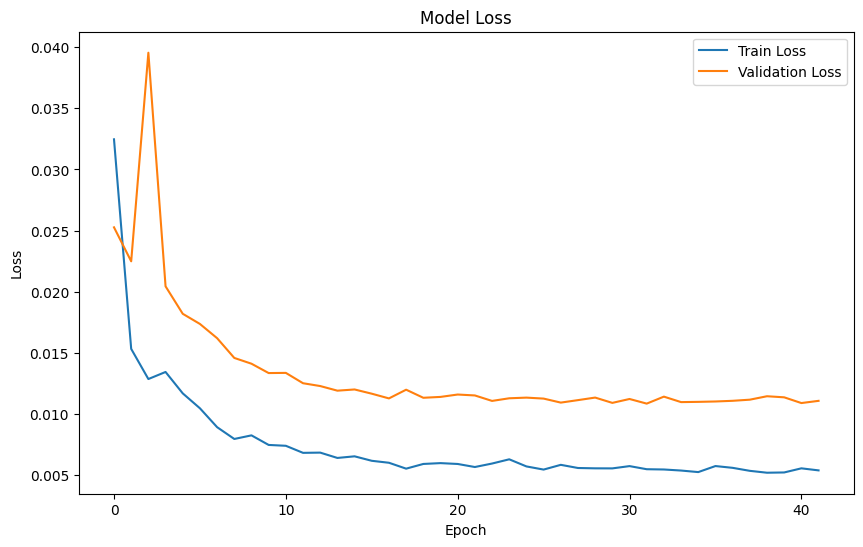

In [9]:
# --- 6. Train the Model ---
# EarlyStopping to stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
batch =  16
history = model.fit(X_train, Y_train,
                    epochs=100, # You can increase epochs, EarlyStopping will handle it
                    batch_size= batch ,
                    validation_split=0.2, # Use a portion of training data for validation
                    callbacks=[early_stopping],
                    verbose=1)

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 200)        │       162,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 848,705 (3.24 MB)

 Trainable params: 282,901 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 565,804 (2.16 MB)

In [11]:
# --- 7. Evaluate the Model ---
train_loss = model.evaluate(X_train, Y_train, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f"\nTrain Loss (MSE): {train_loss:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}")


Train Loss (MSE): 0.0058
Test Loss (MSE): 0.0037


In [12]:
# --- 8. Make Predictions ---
# Make predictions on the test set
Y_pred_scaled = model.predict(X_test)
print(f"\nShape of Y_pred_scaled: {Y_pred_scaled.shape}")
print(f"Shape of Y_test: {Y_test.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Inverse transform the predictions and actual values to the original scale
Y_pred = scaler_target.inverse_transform(Y_pred_scaled)
Y_test_original = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

r2 = r2_score( Y_test_original ,  Y_pred )

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test_original, Y_pred))
print(f"Test RMSE: {rmse:.4f}")

bias =np.mean( Y_pred- Y_test_original)
print(f"Test bias: { bias:.4f}")

# KGE calculation using hydroeval
# Note: hydroeval's kge function returns KGE, r, alpha, beta by default
kge_value, r_comp, alpha_comp, beta_comp = he.kge( Y_pred , Y_test_original)
#print( kge_value)

std_ratio = np.std( Y_pred ) / np.std( Y_test_original ) # standard deviation ratio
correlation = np.corrcoef( Y_pred.flatten() ,  Y_test_original.flatten() )[0, 1]
print("correlation", correlation)

print(np.std(Y_pred))
print(np.std(Y_test_original))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Shape of Y_pred_scaled: (305, 1)
Shape of Y_test: (305,)
Shape of X_test: (305, 90, 2)
Test RMSE: 1.4519
Test bias: -0.4661
correlation 0.9663392206598442
5.1048837
5.3402736397774815


In [13]:



# Example arrays
x = np.array([1, 2, 3, 4, 5])
print(x.shape)
y = np.array([2, 4, 6, 8, 10])

# Compute the correlation coefficient matrix
correlation_matrix = np.corrcoef(x, y)

# Extract the correlation coefficient (Pearson's r)
correlation_example = correlation_matrix[0, 1]

print("Correlation coefficient:", correlation_example)


print("Y_test_original",Y_test_original.shape)
print("Y_test_original",type(Y_test_original) )
print(np.isnan(Y_test_original).sum())
print(np.isinf(Y_test_original).sum())
print("Y_pred",Y_pred.shape)
print("Y_pred",type(Y_pred))
print(np.isnan(Y_pred).sum())
print(np.isinf(Y_pred).sum())

(5,)
Correlation coefficient: 0.9999999999999999
Y_test_original (305, 1)
Y_test_original <class 'numpy.ndarray'>
0
0
Y_pred (305, 1)
Y_pred <class 'numpy.ndarray'>
0
0


In [14]:
#Y_pred
#Y_test_original
#print(Y_pred .shape)
#df_cleaned[train_size:len(Y)]['Date']


#dt_ys = df_cleaned[train_size:len(Y)]#['Date']

print(df_cleaned.tail)
print((len(Y)-Y_test.shape[0]  ))
print(len(Y) )
dt_ys = df_cleaned.iloc[  ( df_cleaned.shape[0]-Y_test.shape[0]  )  : df_cleaned.shape[0] ]#['Date']


print(dt_ys )
dt_ys['Y_pred'] = Y_pred
dt_ys['Y_test_original']= Y_test_original

dt_ys[['Date','Y_pred', 	'Y_test_original']]

dt_ys['Date'] = pd.to_datetime( dt_ys['Date'])

summer_df = dt_ys[ dt_ys['Date'].dt.month.isin([6, 7, 8])]

print(summer_df.tail())

summer_df.to_csv( ( model_site[0] + "summer_df.csv") )

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(summer_df['Y_test_original'], summer_df['Y_pred']))
print(f"Test RMSE: {rmse:.4f}")

<bound method NDFrame.tail of          tmean   site_no       Date  00010_Mean  00060_Mean
4902  0.344081  13307000 2016-03-03    0.196653    0.045422
4903  0.364658  13307000 2016-03-04    0.209205    0.044941
4904  0.445693  13307000 2016-03-05    0.242678    0.045902
4905  0.334190  13307000 2016-03-06    0.246862    0.049267
4906  0.334455  13307000 2016-03-07    0.230126    0.053112
...        ...       ...        ...         ...         ...
8001  0.754131  13307000 2024-08-27    0.769874    0.005239
8002  0.608749  13307000 2024-08-28    0.736402    0.004518
8003  0.704668  13307000 2024-08-29    0.715481    0.003028
8004  0.804984  13307000 2024-08-30    0.736402    0.002211
8005  0.830521  13307000 2024-08-31    0.757322    0.002115

[1612 rows x 5 columns]>
1217
1522
         tmean   site_no       Date  00010_Mean  00060_Mean
7519  0.723060  13307000 2023-05-03    0.493724    0.292958
7520  0.675868  13307000 2023-05-04    0.456067    0.306897
7521  0.585115  13307000 2023-05-0

<ipython-input-14-e1aecc7ee74d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_pred'] = Y_pred
<ipython-input-14-e1aecc7ee74d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_test_original']= Y_test_original
<ipython-input-14-e1aecc7ee74d>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

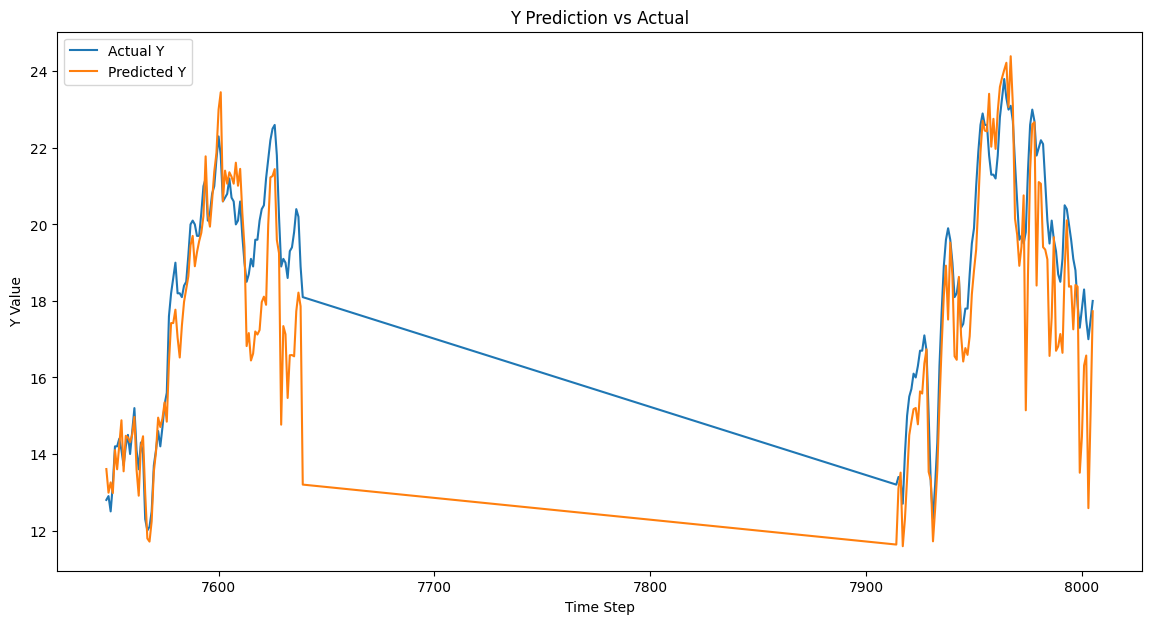

In [15]:
plt.figure(figsize=(14, 7))
plt.plot( summer_df['Y_test_original'], label='Actual Y')
plt.plot( summer_df['Y_pred'], label='Predicted Y')
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

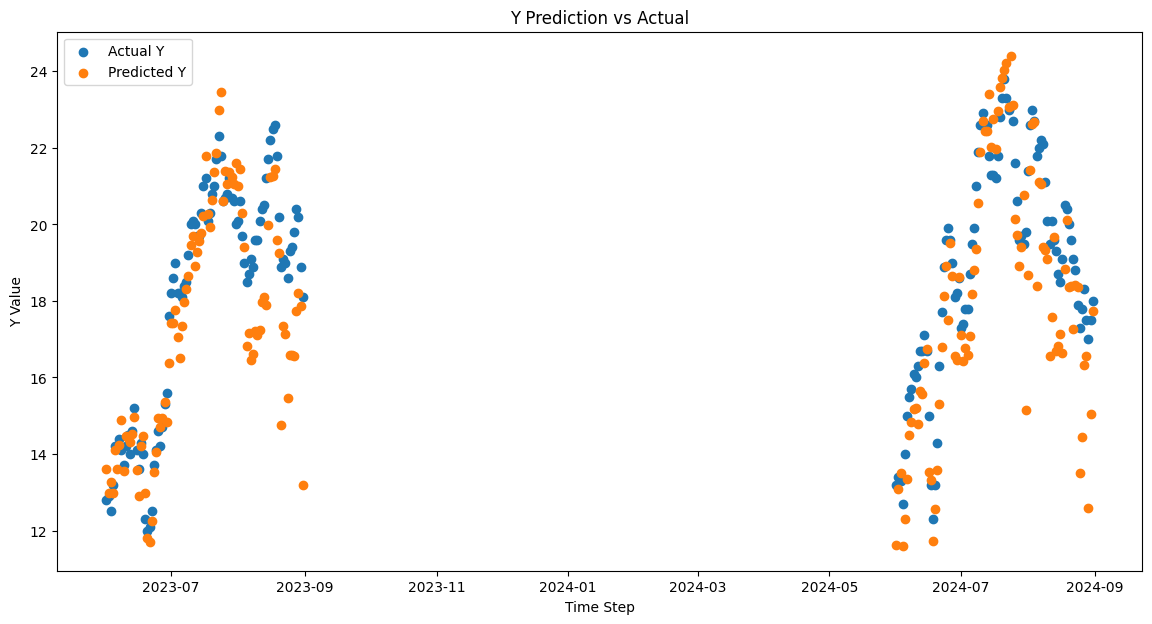

In [16]:
plt.figure(figsize=(14, 7))
plt.scatter(summer_df['Date'], summer_df['Y_test_original'], label='Actual Y')
plt.scatter(summer_df['Date'], summer_df['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

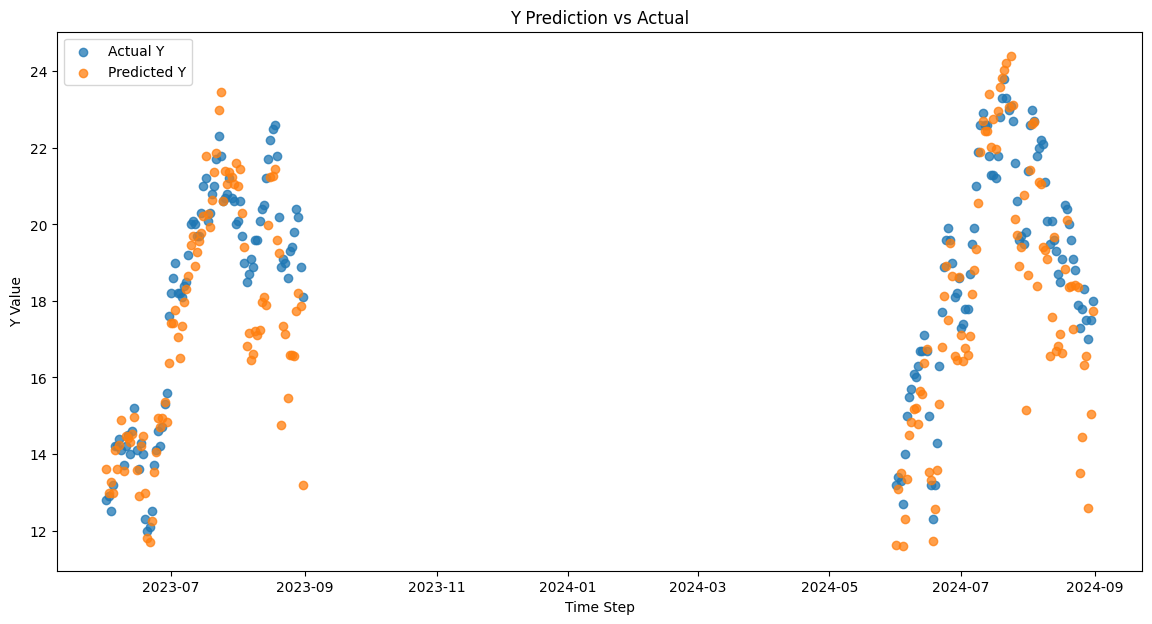

In [17]:
small= summer_df[0:256]
alpha=0.75
plt.figure(figsize=(14, 7))
plt.scatter( small['Date'],  small['Y_test_original'], label='Actual Y',alpha=alpha)
plt.scatter( small['Date'],  small['Y_pred'], label='Predicted Y',alpha=alpha)



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

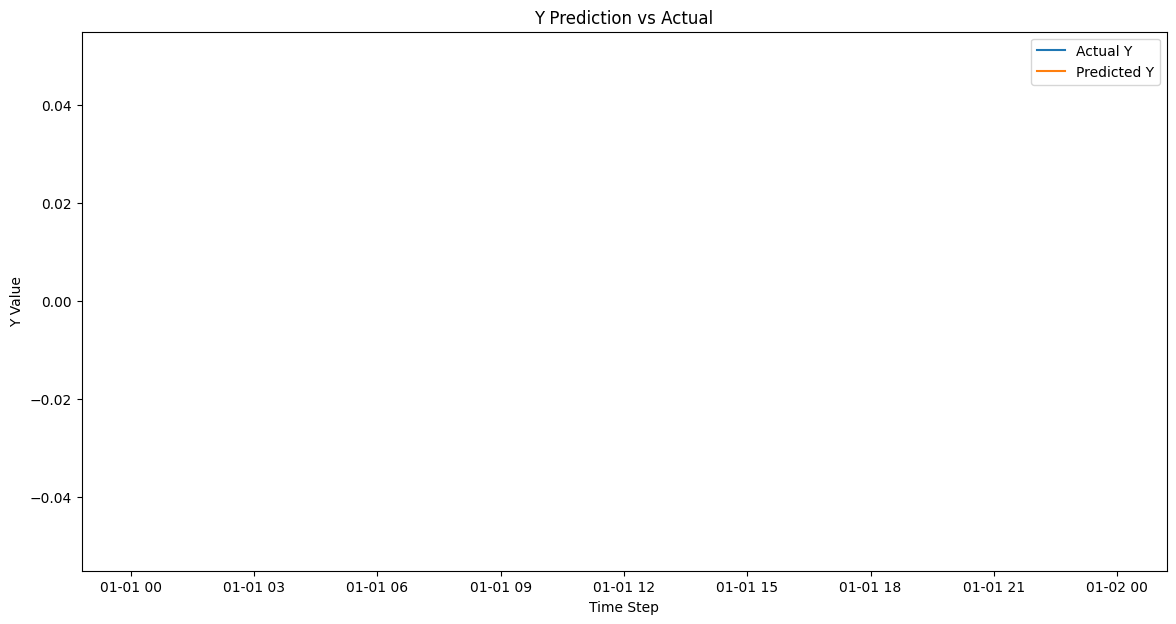

In [18]:
small= summer_df[187:256]

plt.figure(figsize=(14, 7))
plt.plot( small['Date'],  small['Y_test_original'], label='Actual Y')
plt.plot( small['Date'],  small['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

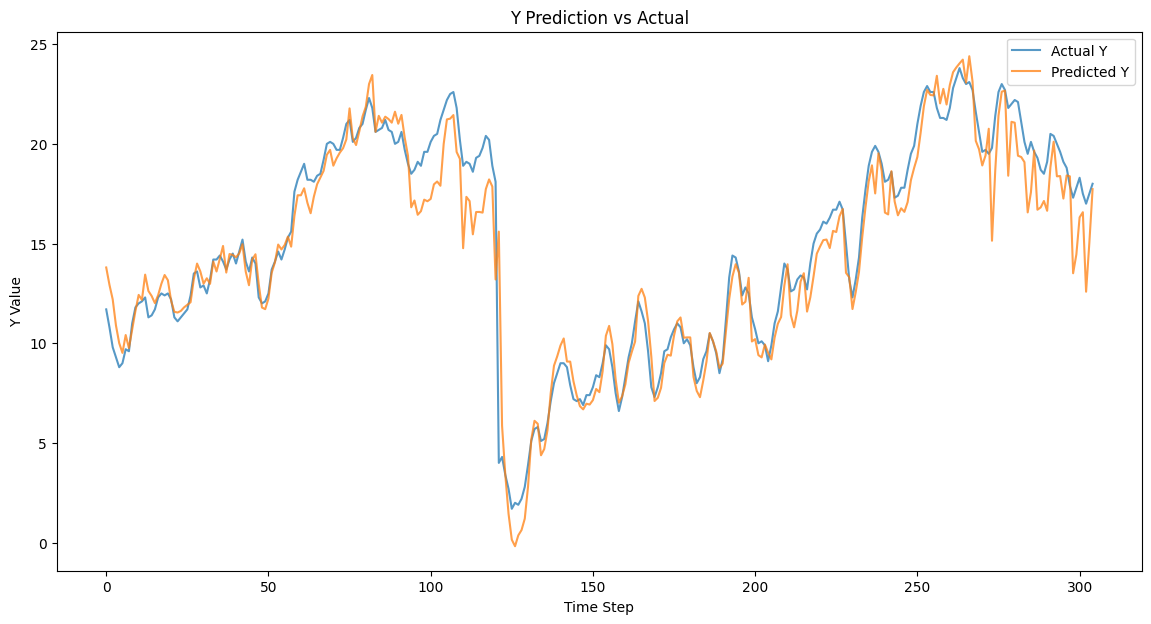

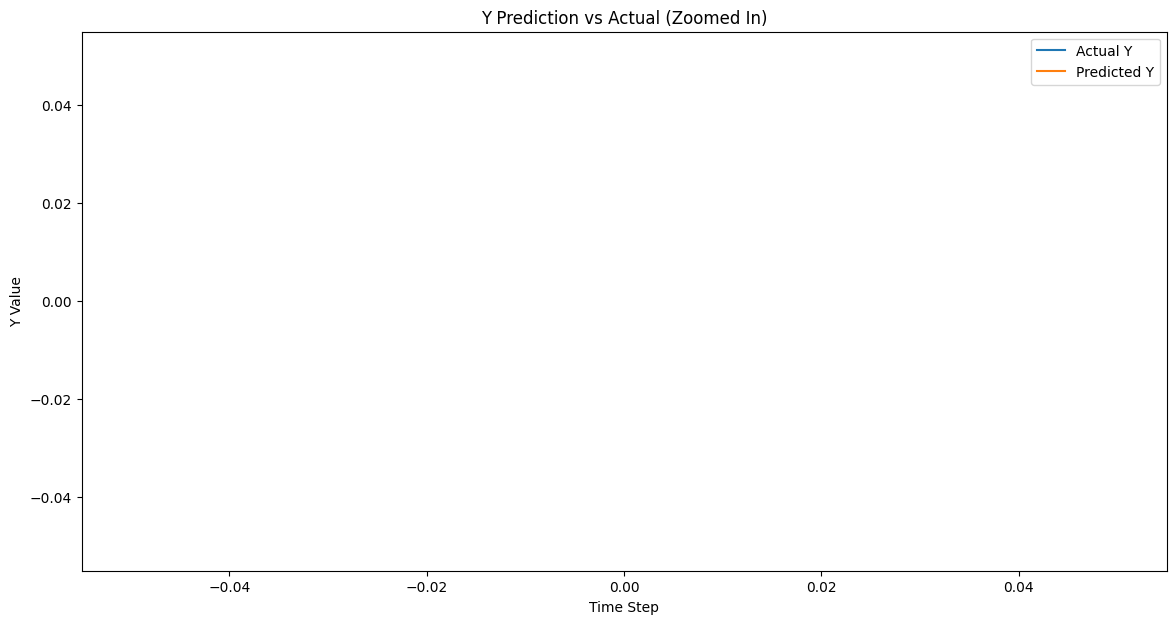

In [19]:



# --- 9. Visualize Predictions vs. Actual ---
plt.figure(figsize=(14, 7))
plt.plot(Y_test_original, label='Actual Y' ,alpha=alpha )
plt.plot(Y_pred, label='Predicted Y' ,alpha=alpha)
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

# Optional: Plot a smaller segment for better detail
plt.figure(figsize=(14, 7))
plt.plot(Y_test_original[1234:1456], label='Actual Y')
plt.plot(Y_pred[ 1234:1456 ], label='Predicted Y')
plt.title('Y Prediction vs Actual (Zoomed In)')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

In [20]:
result_df = pd.DataFrame({
                          "model_site": [model_site[0]],
                          "train_month" : [train_month]
   , "h1":[h1]
                          ,"h2":[h2]
                          ,"d1":[d1]
                          ,"d2":[d2]
                          ,"batch":[batch]
                          ,"look_back":[look_back]


                          ,"optimizer":[optimizer]
    ,'learning_rate':[learning_rate]
    ,"r2" :[r2]
    , "rmse":[rmse]
                           , "bias":[bias]

                       ,   "std_ratio" :[std_ratio]
                        ,  "correlation" :[correlation]


    ,"KGE" : [kge_value]

    })

print(result_df)


result_df.to_csv( model_site[0]+'_result_df.csv' , index=False)

result_df.to_csv('/content/drive/My Drive/LSTM_results/' + model_site[0]+'_result_df_'+   current_time.strftime("%Y%m%d%H%M") + '.csv' , index=False)


  model_site         train_month   h1   h2    d1     d2  batch  look_back  \
0   13307000  [3, 4, 5, 6, 7, 8]  200  100  0.05  0.025     16         90   

                                           optimizer  learning_rate        r2  \
0  <keras.src.optimizers.adam.Adam object at 0x78...          0.001  0.926084   

       rmse      bias  std_ratio  correlation                   KGE  
0  1.505774 -0.466128   0.955922     0.966339  [0.9363302439759237]  


In [21]:
#model.save( (model_site[0]+'_lstm_model.h5') )

         tmean   site_no       Date  00010_Mean  00060_Mean     Y_pred  \
7548  0.647325  13307000 2023-06-01    0.539749    0.466474  13.607003   
7549  0.669888  13307000 2023-06-02    0.543933    0.476087  12.989124   
7550  0.653931  13307000 2023-06-03    0.527197    0.490507  13.259144   
7551  0.739688  13307000 2023-06-04    0.556485    0.471281  12.979678   
7552  0.701618  13307000 2023-06-05    0.598326    0.480894  14.100955   

      Y_test_original      bias  
7548             12.8  0.807003  
7549             12.9  0.089124  
7550             12.5  0.759144  
7551             13.2 -0.220322  
7552             14.2 -0.099045  


<ipython-input-22-2b372042d231>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']


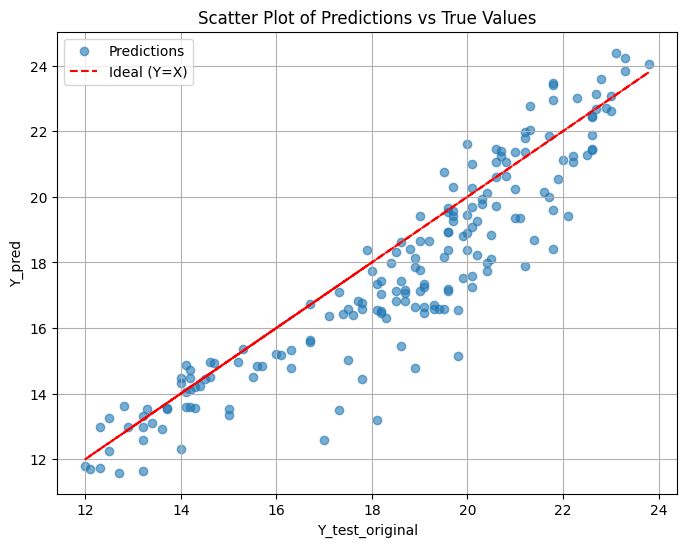

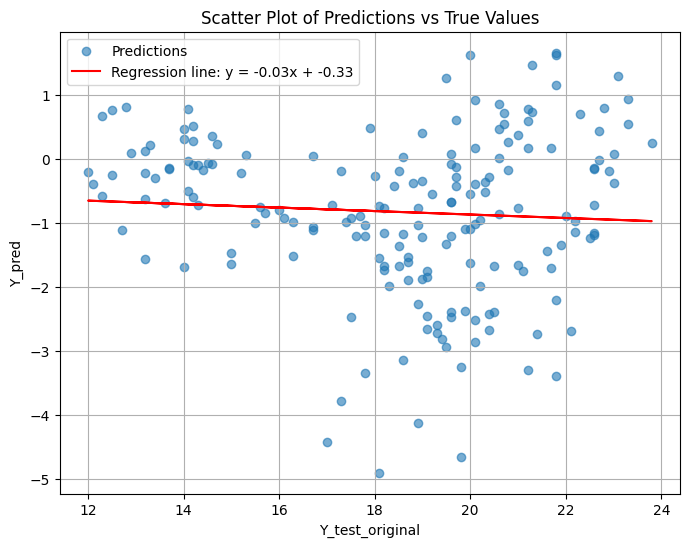

In [22]:
summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']
print( summer_df.head() )

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['Y_pred'], alpha=0.6, label='Predictions')
plt.plot( summer_df['Y_test_original'],  summer_df['Y_test_original'], color='red', linestyle='--', label='Ideal (Y=X)')
plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['bias'], alpha=0.6, label='Predictions')

# Calculate regression line
coefficients = np.polyfit(  summer_df['Y_test_original'],  summer_df['bias'] , 1)  # 1 for linear regression
polynomial = np.poly1d(coefficients)
y_pred = polynomial(  summer_df['Y_test_original']  )
# Plot regression line
plt.plot(  summer_df['Y_test_original'] , y_pred, color='red', label=f'Regression line: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')


plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

https://www.sciencedirect.com/science/article/pii/S2214581824000648#sec0030